In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-08-06 10:39:46.964887: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-08-06 10:39:48.140464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:5e:00.0
2024-08-06 10:39:48.140713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-06 10:39:48.142183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-06 10:39:48.143481: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-08-06 10:39:48.143776: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-08-06 10:39:48.145446: I tensorflow/stream_executor

In [15]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
np.random.seed(42)

In [4]:
tf.random.set_seed(8)

In [5]:
# Defining the CWoLA model
def CWoLA(p_i):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    #x = keras.layers.Input(shape = (p_i,p_i,2), name = "jet1and2")
    #input_1 = keras.layers.Lambda(lambda x: x[:,:,:,0:1])
    #input_2 = keras.layers.Lambda(lambda x: x[:,:,:,1:2])
    #y = input_1(x)
    #z = input_2(x)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")    
    input_3 = keras.layers.Input(shape = (1), name = "mass_jet_1")
    input_4 = keras.layers.Input(shape = (1), name = "mass_jet_2")
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    ann = keras.Sequential([
            keras.layers.Dense(16, activation = 'relu'),
            keras.layers.Dense(8, activation = 'relu'),
            keras.layers.Dense(1, activation = 'sigmoid')
    ])
  
    x_1 = cnn(y)
    x_2 = cnn(z)
    x_3 = ann(input_3)
    x_4 = ann(input_4)
    x_5 = keras.layers.Concatenate()([x_1, x_3])
    x_6 = keras.layers.Concatenate()([x_2, x_4])
    x_5 = dnn(x_5)
    x_6 = dnn(x_6)

    x_out = keras.layers.Multiply()([x_5, x_6])
    return keras.Model(         
    inputs=[input_1, input_2, input_3, input_4],
    outputs=x_out)





In [ ]:
n_train_sr_bkg = 25000
mean_results = []
std_results = []
for p_1 in [25, 50, 75]:#[25, 50, 75]:
    rng = np.random.default_rng()    
    os.chdir('/home/manhducnmd/pp_dijet/Results_full')    
    bkg_sr_jet_1 = np.load(f'test_full_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'test_full_background_images_sr_{p_1}_jet_2.npy')
    bkg_sr_mass_jet_1 = np.load(f'test_full_background_sr_mass_jet_1.npy')
    bkg_sr_mass_jet_2 = np.load(f'test_full_background_sr_mass_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'test_full_background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'test_full_background_images_sb_{p_1}_jet_2.npy')
    bkg_sb_mass_jet_1 = np.load(f'test_full_background_sb_mass_jet_1.npy')
    bkg_sb_mass_jet_2 = np.load(f'test_full_background_sb_mass_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg = int(np.round(n_train_sr_bkg*sb_sr_bkg))
    n_test_sr_bkg = 20000
    
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #Mass ratio, SR
    bkg_pretrain_sr_mass_jet_1 = bkg_sr_mass_jet_1[0:-n_test_sr_bkg]
    bkg_pretrain_sr_mass_jet_2 = bkg_sr_mass_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    #Mass ratio, SB
    bkg_pretrain_sb_mass_jet_1 = bkg_sb_mass_jet_1[0:-n_test_sr_bkg]
    bkg_pretrain_sb_mass_jet_2 = bkg_sb_mass_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'dd10_sr_{p_1}_jet_2.npy')
    signal_sr_mass_jet_1 = np.load(f'dd10_sr_mass_jet_1.npy')
    signal_sr_mass_jet_2 = np.load(f'dd10_sr_mass_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'dd10_sb_{p_1}_jet_2.npy')
    signal_sb_mass_jet_1 = np.load(f'dd10_sb_mass_jet_1.npy')
    signal_sb_mass_jet_2 = np.load(f'dd10_sb_mass_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000] #10000 events are pooled for resampling
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]
        
        #Mass ratio, SR
        signal_pretrain_sr_mass_jet_1 = signal_sr_mass_jet_1[0:20000]
        signal_pretrain_sr_mass_jet_2 = signal_sr_mass_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        #Mass ratio, SB
        signal_pretrain_sb_mass_jet_1 = signal_sb_mass_jet_1[0:20000]
        signal_pretrain_sb_mass_jet_2 = signal_sb_mass_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=7)
        
        rng_3 = np.random.default_rng(seed=66)
        for i in range(10):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg]
            #Mass ratio, background, SR
            bkg_train_sr_mass_jet_1 = (bkg_pretrain_sr_mass_jet_1[indices_2])[0:n_train_sr_bkg]
            bkg_train_sr_mass_jet_2 = (bkg_pretrain_sr_mass_jet_2[indices_2])[0:n_train_sr_bkg]

            
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg]
            #Mass ratio, background, SB
            bkg_train_sb_mass_jet_1 = (bkg_pretrain_sb_mass_jet_1[indices_2])[0:n_train_sb_bkg]
            bkg_train_sb_mass_jet_2 = (bkg_pretrain_sb_mass_jet_2[indices_2])[0:n_train_sb_bkg]

            
            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            signal_train_sr_mass_jet_1 = (signal_pretrain_sr_mass_jet_1[indices_3])[0:n_train_sr_signal]
            signal_train_sr_mass_jet_2 = (signal_pretrain_sr_mass_jet_2[indices_3])[0:n_train_sr_signal]
            
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]
            signal_train_sb_mass_jet_1 = (signal_pretrain_sb_mass_jet_1[indices_3])[0:n_train_sb_signal]
            signal_train_sb_mass_jet_2 = (signal_pretrain_sb_mass_jet_2[indices_3])[0:n_train_sb_signal]
            
            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_sr_mass_jet_1 = np.concatenate((signal_train_sr_mass_jet_1, bkg_train_sr_mass_jet_1))
            train_sr_mass_jet_2 = np.concatenate((signal_train_sr_mass_jet_2, bkg_train_sr_mass_jet_2))

            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_sb_mass_jet_1 = np.concatenate((signal_train_sb_mass_jet_1, bkg_train_sb_mass_jet_1))
            train_sb_mass_jet_2 = np.concatenate((signal_train_sb_mass_jet_2, bkg_train_sb_mass_jet_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)
            
            #x_train_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            #x_train_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            #x_train_mass_ratio = np.concatenate((signal_train_sr_mass_ratio, bkg_train_sr_mass_ratio))
            #y_train = np.concatenate((np.ones(np.shape(signal_train_sr_1)[0], dtype = int), 
                                      #np.zeros(np.shape(bkg_train_sr_1)[0], dtype = int)))
            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            x_train_mass_jet_1 = np.concatenate((train_sr_mass_jet_1, train_sb_mass_jet_1))
            x_train_mass_jet_2 = np.concatenate((train_sr_mass_jet_2, train_sb_mass_jet_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])

            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            #x_train = np.stack([x_train_1, x_train_2], axis = -1)
            x_train_mass_jet_1 = x_train_mass_jet_1[indices]
            x_train_mass_jet_2 = x_train_mass_jet_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            
            cwola = CWoLA(p_1)
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            #history = cwola.fit(x_train, y_train, validation_split = 0.2,
                                #shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2, 'mass_jet_1': x_train_mass_jet_1, 
                                 'mass_jet_2': x_train_mass_jet_2}, 
                                y_train, validation_split = 0.2,
                                  shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/full_run_{i}_dd10_{n_train_sr_signal}_{p_1}.keras')

Training with significance = 0.32, run 0


2024-08-04 18:27:50.275682: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-08-04 18:27:50.312752: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-08-04 18:27:50.315595: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e7d86e2270 executing computations on platform Host. Devices:
2024-08-04 18:27:50.315636: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-08-04 18:27:50.318345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:5e:00.0
2024-08-04 18:27:50.318441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-04 18:27:50.318474: I tenso

Train on 40902 samples, validate on 10226 samples
Epoch 1/1000


2024-08-04 18:27:52.490684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-04 18:27:52.644067: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-08-04 18:27:53.173446: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


40902/40902 [==============================] - 5s 128us/sample - loss: 0.7163 - accuracy: 0.5151 - val_loss: 0.7112 - val_accuracy: 0.5059
Epoch 2/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6976 - accuracy: 0.5151 - val_loss: 0.6956 - val_accuracy: 0.5109
Epoch 3/1000
40902/40902 [==============================] - 3s 69us/sample - loss: 0.6947 - accuracy: 0.5179 - val_loss: 0.6973 - val_accuracy: 0.5059
Epoch 4/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6936 - accuracy: 0.5134 - val_loss: 0.6944 - val_accuracy: 0.5089
Epoch 5/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6934 - accuracy: 0.5184 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 6/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6923 - accuracy: 0.5175 - val_loss: 0.6926 - val_accuracy: 0.5127
Epoch 7/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6925 - accuracy: 0.51

40902/40902 [==============================] - 3s 71us/sample - loss: 0.6901 - accuracy: 0.5309 - val_loss: 0.6947 - val_accuracy: 0.5099
Epoch 30/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6895 - accuracy: 0.5324 - val_loss: 0.6944 - val_accuracy: 0.5113
Epoch 31/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6896 - accuracy: 0.5312 - val_loss: 0.6942 - val_accuracy: 0.5098
Epoch 32/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6889 - accuracy: 0.5327 - val_loss: 0.6940 - val_accuracy: 0.5074
Epoch 33/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6884 - accuracy: 0.5364 - val_loss: 0.6965 - val_accuracy: 0.5082
Epoch 34/1000
40902/40902 [==============================] - 3s 72us/sample - loss: 0.6881 - accuracy: 0.5361 - val_loss: 0.6975 - val_accuracy: 0.5035
Epoch 35/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6879 - accuracy:

Epoch 11/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6922 - accuracy: 0.5187 - val_loss: 0.6921 - val_accuracy: 0.5195
Epoch 12/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6922 - accuracy: 0.5186 - val_loss: 0.6917 - val_accuracy: 0.5252
Epoch 13/1000
40902/40902 [==============================] - 3s 72us/sample - loss: 0.6919 - accuracy: 0.5201 - val_loss: 0.6918 - val_accuracy: 0.5210
Epoch 14/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6916 - accuracy: 0.5242 - val_loss: 0.6923 - val_accuracy: 0.5180
Epoch 15/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6920 - accuracy: 0.5197 - val_loss: 0.6923 - val_accuracy: 0.5157
Epoch 16/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6925 - accuracy: 0.5183 - val_loss: 0.6931 - val_accuracy: 0.5175
Epoch 17/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.69

40902/40902 [==============================] - 3s 73us/sample - loss: 0.6883 - accuracy: 0.5365 - val_loss: 0.6952 - val_accuracy: 0.5101
Epoch 32/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6877 - accuracy: 0.5360 - val_loss: 0.6942 - val_accuracy: 0.5043
Epoch 33/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6872 - accuracy: 0.5392 - val_loss: 0.6946 - val_accuracy: 0.5092
Epoch 34/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6861 - accuracy: 0.5417 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 35/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6845 - accuracy: 0.5467 - val_loss: 0.6969 - val_accuracy: 0.5120
Epoch 36/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6837 - accuracy: 0.5463 - val_loss: 0.7064 - val_accuracy: 0.5107
Epoch 37/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6834 - accuracy:

Epoch 12/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6923 - accuracy: 0.5144 - val_loss: 0.6925 - val_accuracy: 0.5178
Epoch 13/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6922 - accuracy: 0.5162 - val_loss: 0.6935 - val_accuracy: 0.5094
Epoch 14/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6923 - accuracy: 0.5183 - val_loss: 0.6921 - val_accuracy: 0.5179
Epoch 15/1000
40902/40902 [==============================] - 3s 71us/sample - loss: 0.6920 - accuracy: 0.5182 - val_loss: 0.6921 - val_accuracy: 0.5161
Epoch 16/1000
40902/40902 [==============================] - 3s 70us/sample - loss: 0.6922 - accuracy: 0.5168 - val_loss: 0.6931 - val_accuracy: 0.5159
Epoch 17/1000
40902/40902 [==============================] - 3s 72us/sample - loss: 0.6923 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5209
Epoch 18/1000
40902/40902 [==============================] - 3s 72us/sample - loss: 0.69

40954/40954 [==============================] - 3s 70us/sample - loss: 0.6899 - accuracy: 0.5322 - val_loss: 0.6925 - val_accuracy: 0.5182
Epoch 32/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6892 - accuracy: 0.5319 - val_loss: 0.6923 - val_accuracy: 0.5192
Epoch 33/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6888 - accuracy: 0.5350 - val_loss: 0.6923 - val_accuracy: 0.5195
Epoch 34/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6881 - accuracy: 0.5381 - val_loss: 0.6931 - val_accuracy: 0.5162
Epoch 35/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6866 - accuracy: 0.5425 - val_loss: 0.6948 - val_accuracy: 0.5094
Epoch 36/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6856 - accuracy: 0.5437 - val_loss: 0.6976 - val_accuracy: 0.5129
Epoch 37/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6836 - accuracy:

40954/40954 [==============================] - 4s 99us/sample - loss: 0.7174 - accuracy: 0.5152 - val_loss: 0.7031 - val_accuracy: 0.5125
Epoch 2/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.6986 - accuracy: 0.5166 - val_loss: 0.6964 - val_accuracy: 0.5207
Epoch 3/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6938 - accuracy: 0.5198 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 4/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.6936 - accuracy: 0.5168 - val_loss: 0.6930 - val_accuracy: 0.5205
Epoch 5/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.6930 - accuracy: 0.5173 - val_loss: 0.6924 - val_accuracy: 0.5092
Epoch 6/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6928 - accuracy: 0.5174 - val_loss: 0.6944 - val_accuracy: 0.5106
Epoch 7/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.6931 - accuracy: 0.516

40954/40954 [==============================] - 3s 71us/sample - loss: 0.6880 - accuracy: 0.5374 - val_loss: 0.6953 - val_accuracy: 0.5085
Training with significance = 0.63, run 7
Train on 40954 samples, validate on 10239 samples
Epoch 1/1000
40954/40954 [==============================] - 4s 97us/sample - loss: 0.7093 - accuracy: 0.5162 - val_loss: 0.6991 - val_accuracy: 0.5171
Epoch 2/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.6950 - accuracy: 0.5196 - val_loss: 0.6955 - val_accuracy: 0.5084
Epoch 3/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6939 - accuracy: 0.5187 - val_loss: 0.6980 - val_accuracy: 0.4998
Epoch 4/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6928 - accuracy: 0.5202 - val_loss: 0.6942 - val_accuracy: 0.5020
Epoch 5/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6925 - accuracy: 0.5184 - val_loss: 0.6924 - val_accuracy: 0.5218
Epoch 6/1000
409

Epoch 18/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6920 - accuracy: 0.5204 - val_loss: 0.6924 - val_accuracy: 0.5193
Epoch 19/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6920 - accuracy: 0.5193 - val_loss: 0.6935 - val_accuracy: 0.5131
Epoch 20/1000
40954/40954 [==============================] - 3s 72us/sample - loss: 0.6917 - accuracy: 0.5237 - val_loss: 0.6923 - val_accuracy: 0.5167
Epoch 21/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6923 - accuracy: 0.5203 - val_loss: 0.6929 - val_accuracy: 0.5121
Epoch 22/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6919 - accuracy: 0.5211 - val_loss: 0.6937 - val_accuracy: 0.5127
Epoch 23/1000
40954/40954 [==============================] - 3s 70us/sample - loss: 0.6916 - accuracy: 0.5241 - val_loss: 0.6938 - val_accuracy: 0.5102
Epoch 24/1000
40954/40954 [==============================] - 3s 71us/sample - loss: 0.69

41006/41006 [==============================] - 3s 71us/sample - loss: 0.6917 - accuracy: 0.5236 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 26/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6921 - accuracy: 0.5202 - val_loss: 0.6926 - val_accuracy: 0.5090
Epoch 27/1000
41006/41006 [==============================] - 3s 71us/sample - loss: 0.6923 - accuracy: 0.5181 - val_loss: 0.6961 - val_accuracy: 0.5074
Epoch 28/1000
41006/41006 [==============================] - 3s 70us/sample - loss: 0.6921 - accuracy: 0.5208 - val_loss: 0.6941 - val_accuracy: 0.5087
Epoch 29/1000
41006/41006 [==============================] - 3s 70us/sample - loss: 0.6915 - accuracy: 0.5264 - val_loss: 0.6928 - val_accuracy: 0.5145
Epoch 30/1000
41006/41006 [==============================] - 3s 71us/sample - loss: 0.6918 - accuracy: 0.5243 - val_loss: 0.6927 - val_accuracy: 0.5095
Epoch 31/1000
41006/41006 [==============================] - 3s 71us/sample - loss: 0.6913 - accuracy:

41006/41006 [==============================] - 3s 71us/sample - loss: 0.6911 - accuracy: 0.5253 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 35/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6912 - accuracy: 0.5256 - val_loss: 0.6921 - val_accuracy: 0.5170
Epoch 36/1000
41006/41006 [==============================] - 3s 71us/sample - loss: 0.6915 - accuracy: 0.5241 - val_loss: 0.6929 - val_accuracy: 0.5085
Epoch 37/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6912 - accuracy: 0.5257 - val_loss: 0.6929 - val_accuracy: 0.5085
Epoch 38/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6918 - val_accuracy: 0.5182
Epoch 39/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6962 - val_accuracy: 0.5012
Epoch 40/1000
41006/41006 [==============================] - 3s 72us/sample - loss: 0.6925 - accuracy:

In [49]:
print(np.shape(bkg_pretrain_sb_1))

(42939, 25, 25)


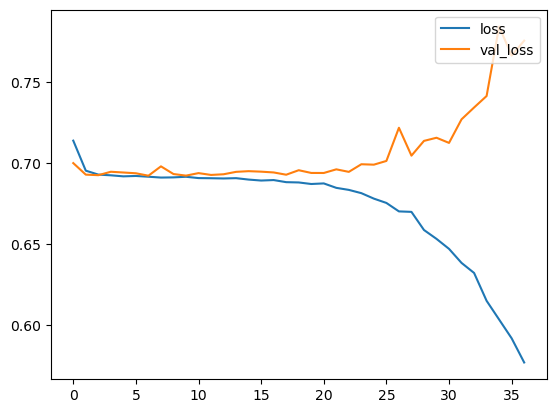

In [185]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

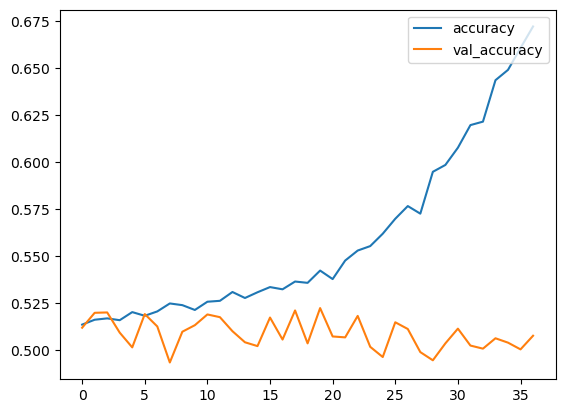

In [186]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [41]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

Loading a sample model for testing

In [56]:
#loaded_model = keras.models.load_model('run_5_id10_500_25.keras')
loaded_model = cwola

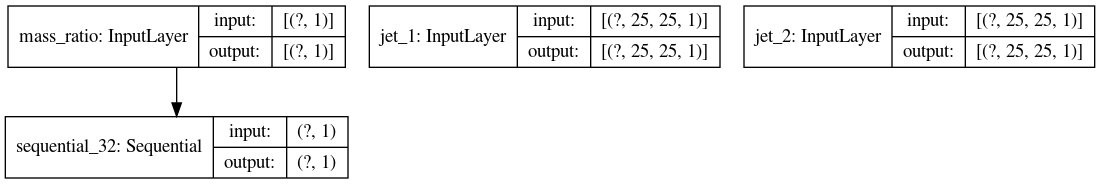

In [66]:
keras.utils.plot_model(loaded_model, "multi_input_and_output_model.png", show_shapes=True)

In [14]:
print(loaded_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [41]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [42]:
bkg_sr_jet_1 = np.load('test_full_background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('test_full_background_images_sr_25_jet_2.npy')
bkg_sr_mass_jet_1 = np.load('test_full_background_sr_mass_jet_1.npy')
bkg_sr_mass_jet_2 = np.load('test_full_background_sr_mass_jet_2.npy')
signal_sr_jet_1 = np.load('dd10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('dd10_sr_25_jet_2.npy')
signal_sr_mass_jet_1 = np.load('dd10_sr_mass_jet_1.npy')
signal_sr_mass_jet_2 = np.load('dd10_sr_mass_jet_2.npy')




In [43]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]
signal_test_mass_jet_1 = signal_sr_mass_jet_1[-20000:]
signal_test_mass_jet_2 = signal_sr_mass_jet_2[-20000:]


bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]
bkg_test_mass_jet_1 = bkg_sr_mass_jet_1[-20000:]
bkg_test_mass_jet_2 = bkg_sr_mass_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
x_test_mass_jet_1 = np.concatenate((signal_test_mass_jet_1, bkg_test_mass_jet_1))
x_test_mass_jet_2 = np.concatenate((signal_test_mass_jet_2, bkg_test_mass_jet_2))

y_test = np.concatenate((test_label_signal, test_label_bkg))

#x_test = np.stack([x_test_1, x_test_2], axis = -1)
x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [44]:
print(bkg_test_mass_jet_1, signal_test_mass_jet_1)

[280.12271118 555.12506104  40.52799988 ... 187.26396179 110.08351135
 475.64117432] [386.4699707  209.20173645 147.66903687 ... 284.79751587 150.13973999
 135.87216187]


In [57]:
x_predict = loaded_model.predict([x_test_1, x_test_2, x_test_mass_jet_1, x_test_mass_jet_2])

In [58]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


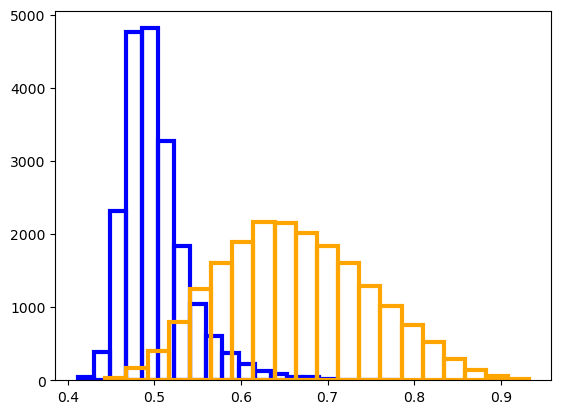

In [59]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()

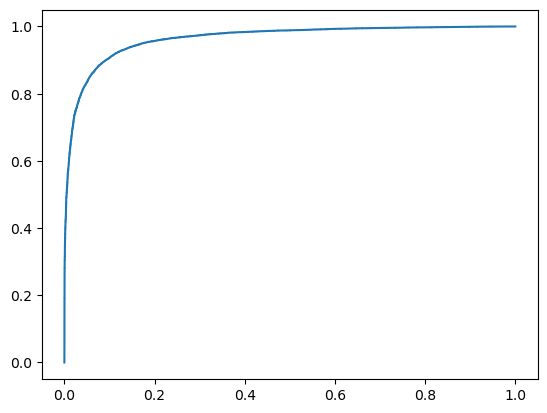

0.9638062362499998


In [60]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [61]:
print(epsilon_s)

[0.32275    0.598      0.90686667]


In [62]:
n_train_sr_signal = 1200

In [65]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[1]+25000*0.01)*np.log(n_train_sr_signal*epsilon_s[1]/(25000*0.01) + 1) - 
                 n_train_sr_signal*epsilon_s[1])))

34.40665825625384
